# AICrowd - Tom and Jerry Emotion Detection Challenge [Link](https://www.aicrowd.com/challenges/tjedc-tom-and-jerry-emotion-detection-challenge)

1. Load and pre-process the data \\ 
    a. Load each image and prepare 5 augmented images (using rotation, shear, zoomed version, horizontal flipping and increasing brightness). \\
    b. Convert these images to array and the labels to categorical form. \\
    c. Split the data into train and validation.

2. Models: \\
List of models choosed. \\
    a. Basic Cifar-10 model architecture. \\
    b. A deep CNN model used for similar challenge. \\
    c. Transfer learning models VGG19. \\
    d. Transfer learning models VGG19 Face. \\
    e. Transfer learning models Resnet50. 

3. Classification Phase:  \\
For each model, the below steps are performed. \\
    a. Prepare the model. \\
    b. Train the model on the data and predict the results on validation. \\
    c. Get metrics such as classification_report and plot confusion matrix.

4. Final Output & Submission

## Google Drive mount and Import statements

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [2]:
%matplotlib inline

!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-b5378717
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-b5378717
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=bf51432755fd6d63568f5cb7554160e03c922a6a78d0e8b2cc946b306bf7427a
  Stored in directory: /tmp/pip-ephem-wheel-cache-nudxgiel/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [0]:
from __future__ import print_function

import numpy as np
import pandas as pd
import os
import itertools
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import InputLayer, Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, AveragePooling2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.regularizers import l2

from keras_vggface.vggface import VGGFace
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19

from tqdm import tqdm

## Data Processing

In [0]:
dir_path = "/gdrive/My Drive/Dataset/AICrowd/EmotionDetection/"

train_img_dir = dir_path + "ntrain/"
test_img_dir = dir_path + "ntest/"

train_dir = dir_path + "train"
test_dir = dir_path + "test" 
validation_dir = dir_path + "validation"

train_df = pd.read_csv(dir_path + "db5fcca9-f52b-42a9-87be-26f77b6f9d97_train.csv")
test_df = pd.read_csv(dir_path + "1062e440-bad5-415c-a209-d3a2a8336c2e_test.csv")

In [0]:
width = 38
height = 38
channels = 3

In [0]:
def load_data(train_df):
    data, labels = list(), list()

    datagen = ImageDataGenerator(
        rotation_range = 40,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        brightness_range = (0.5, 1.5)
        )
    
    for i in tqdm(range(train_df.shape[0])):
        img = load_img(
            '/gdrive/My Drive/Dataset/AICrowd/EmotionDetection/ntrain/'+str(train_df['image_file'][i])+'.jpg',
            target_size=(width, height, channels),
            grayscale=False
            )
        img = img_to_array(img)
        img = img/255.0
        x = img
        data.append(img)
        labels.append(train_df['emotion'][i])
        x = x.reshape((1, ) + x.shape)
        
        # Generating and saving 5 augmented samples using the above defined parameters.
        for index, batch in enumerate(datagen.flow(x, batch_size = 1)):
            if index > 5:
                break
            bat = batch.reshape(width, height, channels)
            bat /= 255.0
            data.append(bat)
            labels.append(train_df['emotion'][i])

    return data, labels

In [7]:
data, labels = load_data(train_df)
data, labels = np.asarray(data), np.asarray(labels)
cat_labels = to_categorical(labels)

100%|██████████| 1941/1941 [22:26<00:00,  1.44it/s]


In [8]:
x_train, x_validation, y_train, y_validation = train_test_split(data, cat_labels, test_size=0.25, stratify=labels)

print(F"Training data stats: {x_train.shape}, {y_train.shape}")
print(F"Validation data stats: {x_validation.shape}, {y_validation.shape}")

Training data stats: (10190, 38, 38, 3), (10190, 5)
Validation data stats: (3397, 38, 38, 3), (3397, 5)


## Classification

In [0]:
epochs = 50
batch_size = 32
num_labels = 5

num_features = 32

### 1. CIFAR-10 CNN

In [0]:
def cifar_10_arch():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(width, height, channels), activation="relu"))
    model.add(Conv2D(32, (3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_labels, activation="softmax"))

    print(model.summary())

    opt = RMSprop(learning_rate=0.0001, decay=1e-6)
    
    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    return model

In [38]:
cifar10_model = cifar_10_arch()

history = cifar10_model.fit(x_train, y_train, 
                            epochs=epochs, 
                            batch_size=batch_size, 
                            validation_data=(x_validation, y_validation))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 38, 38, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 36, 36, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 18, 18, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)         

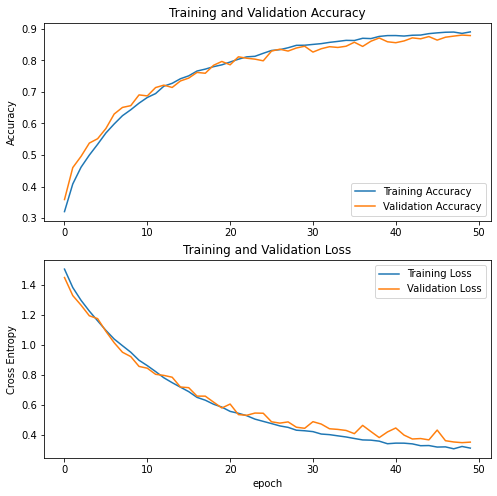

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [40]:
predictions = cifar10_model.predict(x_validation)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_pred, np.argmax(y_validation, axis=1))
cr_report = classification_report(y_pred, np.argmax(y_validation, axis=1))

print(cr_report)

              precision    recall  f1-score   support

           0       0.89      0.83      0.86       656
           1       0.84      0.90      0.87       743
           2       0.86      0.88      0.87       332
           3       0.86      0.84      0.85       769
           4       0.92      0.93      0.93       897

    accuracy                           0.88      3397
   macro avg       0.88      0.88      0.88      3397
weighted avg       0.88      0.88      0.88      3397



[[545  40  15  35  21]
 [ 11 665   5  41  21]
 [  8   4 293  18   9]
 [ 29  59  17 645  19]
 [ 16  23   9  12 837]]


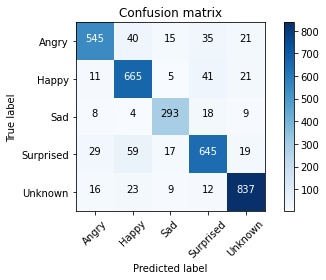

In [41]:
labels = ['Angry', 'Happy', 'Sad', 'Surprised', 'Unknown']
title='Confusion matrix'
print(cm)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

### 2. FER 13

https://github.com/gitshanks/fer2013/blob/master/fertrain.py

In [0]:
def fer13_model_arch():
    model = Sequential()

    model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 3), data_format='channels_last', kernel_regularizer=l2(0.01)))
    model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(2*2*2*num_features, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2*2*num_features, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2*num_features, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_labels, activation='softmax'))

    print(model.summary())

    #Compliling the model with adam optimixer and categorical crossentropy loss
    model.compile(loss="categorical_crossentropy",
                  optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
                  metrics=['accuracy'])

    return model

In [0]:
fer13_model = fer13_model_arch()

history = fer13_model.fit(x_train, y_train, epochs=epochs, validation_data=(x_validation, y_validation))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 36, 36, 32)        896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 36, 36, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 36, 36, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 18, 18, 64)        18496     
_________________________________________________________________
batch_normalization_9 (Batch (None, 18, 18, 64)       

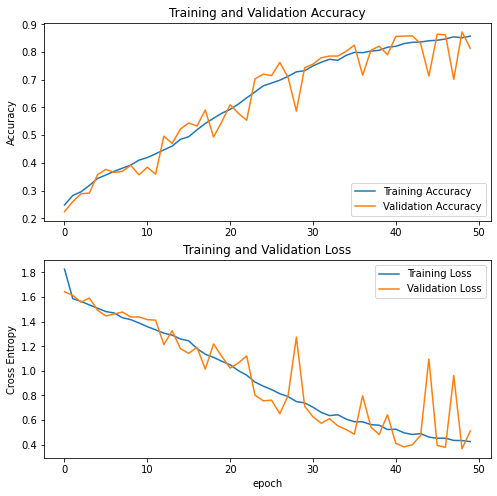

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
predictions = fer13_model.predict(x_validation)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_pred, np.argmax(y_validation, axis=1))
cr_report = classification_report(y_pred, np.argmax(y_validation, axis=1))

print(cr_report)

              precision    recall  f1-score   support

           0       0.89      0.71      0.79       768
           1       0.85      0.76      0.80       890
           2       0.86      0.81      0.84       360
           3       0.60      0.88      0.72       516
           4       0.88      0.93      0.90       863

    accuracy                           0.81      3397
   macro avg       0.82      0.82      0.81      3397
weighted avg       0.83      0.81      0.82      3397



[[543  75  20  85  45]
 [ 30 673   3 146  38]
 [  8   4 293  41  14]
 [ 17  22  13 454  10]
 [ 11  17  10  25 800]]


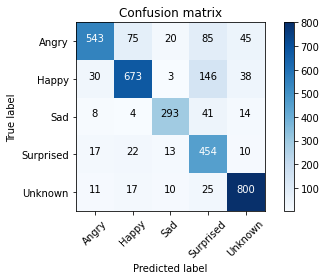

In [0]:
labels = ['Angry', 'Happy', 'Sad', 'Surprised', 'Unknown']
title='Confusion matrix'
print(cm)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

## Final output & Submission


In [30]:
test_data = list()

for i in tqdm(range(test_df.shape[0])):
    img = load_img(
        '/gdrive/My Drive/Dataset/AICrowd/EmotionDetection/ntest/'+str(test_df['image_file'][i])+'.jpg',
        target_size=(width, height, channels),
        grayscale=False
        )
    img = img_to_array(img)
    img /= 255.0
    x = img
    test_data.append(img)

test_data = np.asarray(test_data)

print(F"Test data stats: {test_data.shape}")

100%|██████████| 275/275 [00:01<00:00, 243.59it/s]

Test data stats: (275, 38, 38, 3)


In [0]:
predictions = cifar10_model.predict(test_data)
y_pred = np.argmax(predictions, axis=1)

In [0]:
pd.DataFrame({"emotion": y_pred}).to_csv("/gdrive/My Drive/Dataset/AICrowd/EmotionDetection/submission.csv", index=False)